In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from mist_cf import common
from mist_cf.common.plot_utils import *
set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fig_folder = Path("../results/figures/")
fig_folder = fig_folder / "sirius_compare"
fig_folder.mkdir(parents=True, exist_ok=True)
# mdkir
fig_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path("../data/nist_canopus/")
# rdbe_labels_file = data_folder / "decoy_labels/decoy_label_RDBE.tsv"
labels_file = data_folder / "labels.tsv"
labels = pd.read_csv(labels_file, sep="\t")

fold_nums = [1,2,3]
fold_to_specs = {}
for fold in fold_nums:
    split_file = data_folder / f"splits/split_{fold}.tsv"
    split_df = pd.read_csv(split_file, sep="\t")
    # Get all "spec" where "Fold_0" == "test"
    test_spec = split_df[split_df["Fold_0"] == "test"]["spec"].values
    fold_to_specs[int(fold)] = test_spec

# Get digit at end of split
get_spec_num = lambda x: int(x.split("_")[-1])

split_lens = {k: len(v) for k, v in fold_to_specs.items()}

## Benchmark load results

In [3]:
res_folders = {
    "mist_cf_ms2": ["../results/mist_cf_predict_sirius/"],
    "sirius" : ["../results/sirius_gnps_pred/"]
}

sirius_order = [i for i in sirius_order if i in res_folders.keys()]

In [4]:
dict_list = [{"model": model_name, "folder": f} 
             for model_name, folder_list in res_folders.items() 
             for f in folder_list]

In [5]:
all_dfs = []
for entry in dict_list:
    folder = Path(entry["folder"])
    model = entry['model']
    # load results
    res_files = folder.rglob("full_out.tsv")
    for res_file in res_files:
        split = res_file.parent.parent.name
        df = pd.read_csv(res_file, sep="\t")
        df['split'] = split
        df['model'] = model
        all_dfs.append(df)
all_df = pd.concat(all_dfs, ignore_index=True)

In [6]:
all_df.groupby(["model", "split",]).mean()

ind_found  ind_found_adduct  ind_found_full_form  \
model       split                                                          
mist_cf_ms2 mist_cf_1   57.035828          1.247619            64.155556   
            mist_cf_2   51.072418          1.240948            57.456862   
            mist_cf_3   53.435981          1.184112            56.328505   
sirius      sirius_1   350.227388        156.322890           216.436079   
            sirius_2   371.414351        163.407276           231.540677   
            sirius_3   332.362441        130.615466           223.526565   

                             mass  Top 1 acc.  Top 2 acc.  Top 3 acc.  \
model       split                                                       
mist_cf_ms2 mist_cf_1  409.903700    0.707483    0.833560    0.865760   
            mist_cf_2  426.669381    0.709432    0.831471    0.876620   
            mist_cf_3  413.436656    0.737383    0.861682    0.893925   
sirius      sirius_1   377.470263    0.446185    0.536635    0.571501   
            sirius_2   390.888572    0.429005    0.514907    0.558868   
            sirius_3   374.032167    0.456602    0.566544    0.608101   

                       Top 4 acc.  Top 5 acc.  Top 6 acc.  ...  Top 10 acc.  \
model       split                                          ...                
mist_cf_ms2 mist_cf_1    0.882540    0.892517    0.897959  ...     0.916553   
            mist_cf_2    0.897631    0.908359    0.914618  ...     0.926688   
            mist_cf_3    0.903738    0.911215    0.913551  ...     0.924299   
sirius      sirius_1     0.597271    0.610915    0.623547  ...     0.650834   
            sirius_2     0.586155    0.594240    0.605862  ...     0.628600   
            sirius_3     0.629143    0.644398    0.651236  ...     0.668595   

                       Top 20 acc.  Top 50 acc.  Top 100 acc.  Top 200 acc.  \
model       split                                                             
mist_cf_ms2 mist_cf_1     0.931519     0.942404      0.945125      0.945125   
            mist_cf_2     0.937863     0.943675      0.946804      0.949933   
            mist_cf_3     0.936916     0.945794      0.948131      0.948131   
sirius      sirius_1      0.651339     0.651339      0.651339      0.651339   
            sirius_2      0.630116     0.630116      0.630116      0.630116   
            sirius_3      0.669122     0.669122      0.669122      0.669122   

                       Top 300 acc.  Top 400 acc.  Top 500 acc.  Top 600 acc.  \
model       split                                                               
mist_cf_ms2 mist_cf_1      0.945125      0.945125      0.945125      0.945125   
            mist_cf_2      0.951721      0.951721      0.951721      0.951721   
            mist_cf_3      0.948598      0.948598      0.948598      0.948598   
sirius      sirius_1       0.651339      0.651339      0.651339      0.651339   
            sirius_2       0.630116      0.630116      0.630116      0.630116   
            sirius_3       0.669122      0.669122      0.669122      0.669122   

                       Top 1000 acc.  
model       split                     
mist_cf_ms2 mist_cf_1       0.945125  
            mist_cf_2       0.951721  
            mist_cf_3       0.948598  
sirius      sirius_1        0.651339  
            sirius_2        0.630116  
            sirius_3        0.669122  

[6 rows x 23 columns]

In [7]:
# Get mass range
range_left = [0] + list(range(200, 1000, 100))
range_right = [200] + list(range(300, 1100, 100))
mr_str = [f"[{str(le)}, {str(re)}]" 
          for le, re in zip(range_left, range_right)]

# Rel diff
rel_left = [0, 1e-9, 1e-6, 1e-3, 0.1, 1, 5, 10, 20]
rel_right = [1e-9, 1e-6, 1e-3, 0.1, 1, 5, 20, 999999]
def digitize_mass(parent): 
    mass_bin = np.digitize(parent, bins=range_right)
    if mass_bin > len(mr_str) - 1:
        mass_bin_str = f">{max(range_right)}"
    else:
        mass_bin_str = mr_str[mass_bin]
    return mass_bin_str #TODO: Add mass bin to this labels = 

parentmasses = []
for _, row in labels.iterrows():
    parentmasses.append(common.formula_mass(row["formula"]) + common.ion_to_mass[row["ionization"]])
parentmassbins = [digitize_mass(i) for i in parentmasses]
labels['parentmassbins'] = parentmassbins
spec_to_bin = dict(zip(labels["spec"], labels["parentmassbins"]))
spec_to_adduct = dict(zip(labels["spec"], labels["ionization"]))

## Build table

In [27]:
# Group by method, split, and compute top k accuracy through 20
def top_k_accuracy(x, top_k, denom, key_str="ind_found"):
    k_dict = []
    for k in top_k: 
        acc = np.sum(x[key_str] <= k)  / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict
split_extract = lambda x: f"split_{x.split('_')[-1]}"

top_k = [1, 2, 3, 4, 5]
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split"]#, "mass_bin"]
key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        denom = split_lens[get_spec_num(names[1])]
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str, denom=denom)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts ])
    num_submitted = int(len(sub_df))
    out_df.append(dict(k="num_submitted", val="num_submitted", acc=num_submitted,  **update_dict))
# print(out_df)
tbl_df = pd.DataFrame(out_df)


# Create latex table

# Group by split and model and take mean and std
# Reset split from index
mean_df = tbl_df.groupby(["model", "val", "k"]).mean().reset_index().round(3).sort_index()
std_df = tbl_df.groupby(["model", "val", "k"]).std().reset_index().round(3).sort_index().replace(np.nan, 0)

# display(mean_df), display(std_df)
# Loop over both dfs and create a new df using only thea ccuracy coolumn
error_df = mean_df.copy()
# str concat mean df and std df
error_df["acc"] = [rf"${mean_df['acc'][i]:.3f} \pm {std_df['acc'][i]:.3f}$" for i in range(len(mean_df))]
display(error_df)


# Filter or pivot if needed
# Get val in columsn, acc in rows, and model in index
temp_df = error_df.pivot(index=["model"], columns=["val", "k"], values="acc")
display(temp_df)

,model,val,k,acc
0,mist_cf_ms2,ind_found,1,$0.718 \pm 0.017$
1,mist_cf_ms2,ind_found,2,$0.842 \pm 0.017$
2,mist_cf_ms2,ind_found,3,$0.879 \pm 0.014$
3,mist_cf_ms2,ind_found,4,$0.895 \pm 0.011$
4,mist_cf_ms2,ind_found,5,$0.904 \pm 0.010$
5,mist_cf_ms2,ind_found_adduct,1,$0.834 \pm 0.017$
6,mist_cf_ms2,ind_found_adduct,2,$0.961 \pm 0.012$
7,mist_cf_ms2,ind_found_adduct,3,$0.988 \pm 0.004$
8,mist_cf_ms2,ind_found_adduct,4,$0.995 \pm 0.002$
9,mist_cf_ms2,ind_found_adduct,5,$0.999 \pm 0.001$


val                  ind_found                                        \
k                            1                  2                  3   
model                                                                  
mist_cf_ms2  $0.718 \pm 0.017$  $0.842 \pm 0.017$  $0.879 \pm 0.014$   
sirius       $0.395 \pm 0.014$  $0.480 \pm 0.024$  $0.516 \pm 0.023$   

val                                                 ind_found_adduct  \
k                            4                  5                  1   
model                                                                  
mist_cf_ms2  $0.895 \pm 0.011$  $0.904 \pm 0.010$  $0.834 \pm 0.017$   
sirius       $0.538 \pm 0.020$  $0.549 \pm 0.023$  $0.613 \pm 0.013$   

val                                                                   \
k                            2                  3                  4   
model                                                                  
mist_cf_ms2  $0.961 \pm 0.012$  $0.988 \pm 0.004$  $0.995 \pm 0.002$   
sirius       $0.724 \pm 0.019$  $0.755 \pm 0.016$  $0.758 \pm 0.016$   

val                            ind_found_full_form                     \
k                            5                   1                  2   
model                                                                   
mist_cf_ms2  $0.999 \pm 0.001$   $0.802 \pm 0.004$  $0.874 \pm 0.008$   
sirius       $0.758 \pm 0.016$   $0.477 \pm 0.007$  $0.577 \pm 0.015$   

val                                                                   \
k                            3                  4                  5   
model                                                                  
mist_cf_ms2  $0.898 \pm 0.007$  $0.909 \pm 0.006$  $0.916 \pm 0.006$   
sirius       $0.618 \pm 0.013$  $0.645 \pm 0.008$  $0.658 \pm 0.012$   

val                  num_submitted  
k                    num_submitted  
model                               
mist_cf_ms2  $2194.000 \pm 49.427$  
sirius       $1953.000 \pm 45.033$

In [28]:
71 - 48

23

## Build table orthogonally using already predicted results

Note this method should not be considered as the denominator is only for predicts made.

In [9]:
# Note not to use this table!
# Build accuracy table
top_k = list(range(1,4))
tbl_df = all_df.copy()


keep_rename_map = {f"Top {k} acc.":k for k in top_k}
keep_keys = list(keep_rename_map.keys())

# Group by split and model and take mean and std
agg_df = tbl_df.groupby(["model", "split"]).mean()[keep_keys].sort_index().reset_index()

# Reset split from index
mean_df = agg_df.groupby(["model"]).mean().reset_index().round(3).sort_index()
std_df = agg_df.groupby(["model"]).std().reset_index().round(3).sort_index().replace(np.nan, 0)

error_df = mean_df.copy()
for k in keep_keys: 
    # str concat mean df and std df
    error_df[k] = [rf"${mean_df[k][i]:.3f} \pm {std_df[k][i]:.3f}$" for i in range(len(mean_df))]

# Melt so keys are "Model" "dataset" and "top k"
error_df = error_df.melt(id_vars=["model"], var_name="Top k", value_name="Accuracy")
# Pivot so it's a multi index of "Dataset", "Top k, with "Accuracy" as values 
error_df = error_df.pivot(columns=["Top k"], index="model", values="Accuracy")
error_df.index.name = "Method"

# Sort by max subpeaks
error_df = error_df.sort_index(ascending=True)

display(error_df)
latex = error_df.to_latex(caption="MIST-CF vs. SIRIUS", 
                        label="tab:sirius_compare",
                        escape=False)
print(latex)

Top k,Top 1 acc.,Top 2 acc.,Top 3 acc.
Method,,,
mist_cf_ms2,$0.718 \pm 0.017$,$0.842 \pm 0.017$,$0.879 \pm 0.014$
sirius,$0.444 \pm 0.014$,$0.539 \pm 0.026$,$0.579 \pm 0.026$


\begin{table}
\centering
\caption{MIST-CF vs. SIRIUS}
\label{tab:sirius_compare}
\begin{tabular}{llll}
\toprule
Top k &         Top 1 acc. &         Top 2 acc. &         Top 3 acc. \\
Method      &                    &                    &                    \\
\midrule
mist_cf_ms2 &  $0.718 \pm 0.017$ &  $0.842 \pm 0.017$ &  $0.879 \pm 0.014$ \\
sirius      &  $0.444 \pm 0.014$ &  $0.539 \pm 0.026$ &  $0.579 \pm 0.026$ \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_1567906/1009842941.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = error_df.to_latex(caption="MIST-CF vs. SIRIUS",


## Analysis of which compounds were able to be formula-mapped

In [10]:
count_df = all_df.groupby(["model", "split"]).count().reset_index()

In [11]:
count_df

,model,split,spec,ind_found,ind_found_adduct,ind_found_full_form,mass,mass_bin,true_form,true_ion,...,Top 10 acc.,Top 20 acc.,Top 50 acc.,Top 100 acc.,Top 200 acc.,Top 300 acc.,Top 400 acc.,Top 500 acc.,Top 600 acc.,Top 1000 acc.
0,mist_cf_ms2,mist_cf_1,2205,2205,2205,2205,2205,2205,2205,2205,...,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205
1,mist_cf_ms2,mist_cf_2,2237,2237,2237,2237,2237,2237,2237,2237,...,2237,2237,2237,2237,2237,2237,2237,2237,2237,2237
2,mist_cf_ms2,mist_cf_3,2140,2140,2140,2140,2140,2140,2140,2140,...,2140,2140,2140,2140,2140,2140,2140,2140,2140,2140
3,sirius,sirius_1,1979,1979,1979,1979,1979,1979,1979,1979,...,1979,1979,1979,1979,1979,1979,1979,1979,1979,1979
4,sirius,sirius_2,1979,1979,1979,1979,1979,1979,1979,1979,...,1979,1979,1979,1979,1979,1979,1979,1979,1979,1979
5,sirius,sirius_3,1901,1901,1901,1901,1901,1901,1901,1901,...,1901,1901,1901,1901,1901,1901,1901,1901,1901,1901


,split,model,spec,max_spec,frac_predicted
3,1,sirius,1979,2205,89.750567
4,2,sirius,1979,2237,88.466696
5,3,sirius,1901,2140,88.831776


/tmp/ipykernel_1567906/236789095.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_df = model_df.mean(0)
/tmp/ipykernel_1567906/236789095.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_df = model_df.std(0).replace(np.nan, 0)


,split,model,spec,max_spec,frac_predicted
0,1,mist_cf_ms2,2205,2205,100.0
1,2,mist_cf_ms2,2237,2237,100.0
2,3,mist_cf_ms2,2140,2140,100.0


/tmp/ipykernel_1567906/236789095.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_df = model_df.mean(0)
/tmp/ipykernel_1567906/236789095.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_df = model_df.std(0).replace(np.nan, 0)
/tmp/ipykernel_1567906/236789095.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(i)}%" for i in vals])


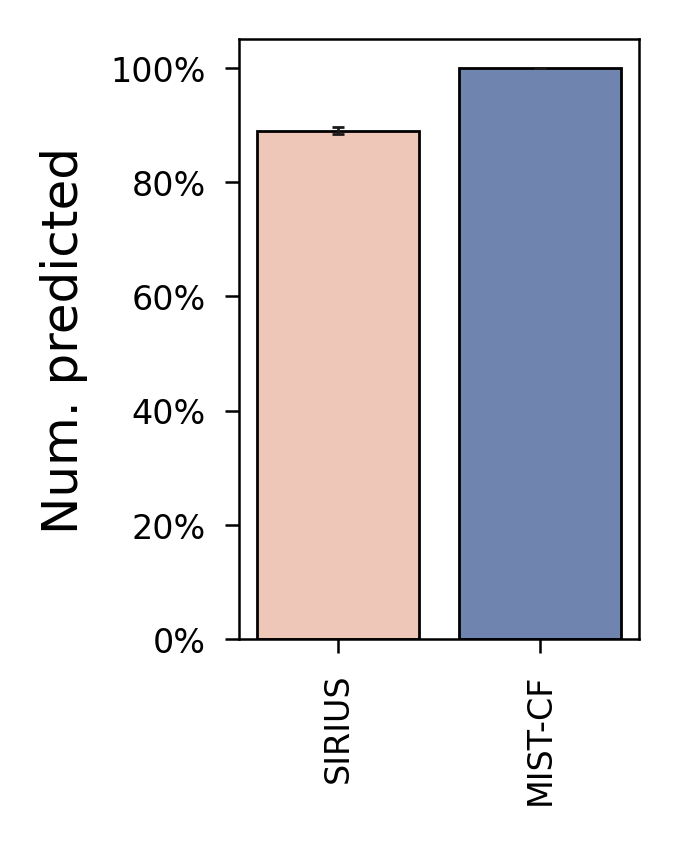

In [12]:
num_bars = len(sirius_order)
figsize = (1, 1.5)

# Build barplot
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.add_subplot(111)

considered_folds = set()
for ind, model in enumerate(sirius_order):
    model_df = count_df[count_df["model"] == model].copy()
    considered_folds.update(set(model_df["split"].apply(get_spec_num).unique()))

    # Get all splits
    splits = model_df["split"].unique()
    split_nums = [get_spec_num(i) for i in splits]
    max_specs = [len(fold_to_specs[i]) for i in split_nums]
    model_df['split']  = model_df['split'].apply(get_spec_num)
    model_df['max_spec'] = [split_lens[i] for i in model_df['split']]
    model_df['frac_predicted'] = model_df['spec'] / model_df['max_spec'] * 100

    model_df = model_df[["split", "model", "spec", "max_spec", "frac_predicted",]].sort_values(by=["split"])

    # Groupby split and compute average 
    display(model_df)
    mean_df = model_df.mean(0)
    std_df = model_df.std(0).replace(np.nan, 0)

    # Verify only length 1 in each of these 
    # assert len(mean_df) == 1
    # assert len(std_df) == 1

    mean = mean_df['frac_predicted']#[0] 
    std = std_df['frac_predicted']#[0]
    ci = std * 1.96 / np.sqrt(len(splits))

    # Plot
    ax.bar(ind, mean, yerr=std, color=color_scheme[model], label=rename_scheme[model],
    # Add black outline
    edgecolor='black', linewidth=0.5, error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
    )

# Set xticks
ax.set_xticks(range(num_bars))
ax.set_xticklabels([rename_scheme[model] for model in sirius_order], rotation=90, ha="center")
ax.set_ylabel("Num. predicted")
# Switch y ticks to be percentages
vals = ax.get_yticks()
ax.set_yticklabels([f"{int(i)}%" for i in vals])

# Save to figure
set_size(*figsize, ax)
fig.savefig(fig_folder / "sirius_compare_num_predicted.pdf", bbox_inches="tight", transparent=True,)



In [13]:
# For all the spectra that could vs. couldn't be predicted by sirius 
# Build distributions of their masses

# Get all the spectra that could be predicted by sirius
all_specs = {j for k, v in fold_to_specs.items() for j in v if k in considered_folds}
predicted_specs = set(all_df[all_df["model"] == "sirius"]["spec"].values)
missed = all_specs.difference(predicted_specs)
found = all_specs.intersection(predicted_specs)
print(f"Found {len(found)} spectra")
print(f"Missed {len(missed)} spectra")
# Missed percentage
print(f"Missed {len(missed) / len(all_specs) * 100:.2f}% spectra")
print(f"Total {len(all_specs)} spectra")
assert(len(all_specs) == len(found) + len(missed))

Found 4755 spectra
Missed 574 spectra
Missed 10.77% spectra
Total 5329 spectra


In [14]:
# Map labels "spec" to "formula"
spec_to_form = dict(zip(labels["spec"], labels["formula"]))
found_form = [spec_to_form[i] for i in found]
missed_form = [spec_to_form[i] for i in missed]
from mist_cf import common
found_masses = [common.formula_mass(i) for i in found_form]
missed_masses = [common.formula_mass(i) for i in missed_form]
print(f"Found {len(found_masses)} masses")
print(f"Missed {len(missed_masses)} masses")
# Print avg of dists
print(f"Found avg: {np.mean(found_masses):.2f} std: {np.std(found_masses):.2f}")
print(f"Missed avg: {np.mean(missed_masses):.2f} std: {np.std(missed_masses):.2f}")

Found 4755 masses
Missed 574 masses
Found avg: 378.06 std: 130.32
Missed avg: 700.80 std: 147.04


/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


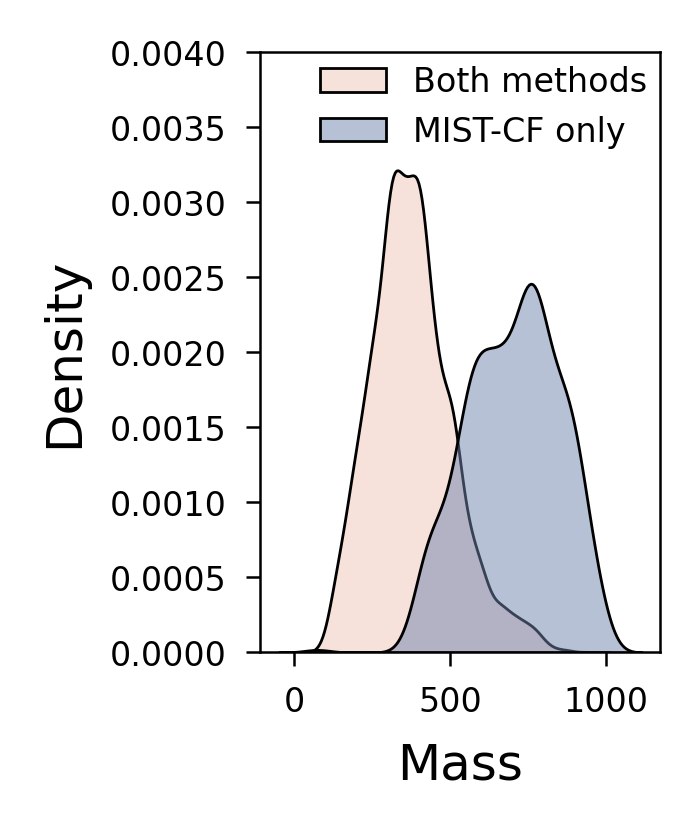

In [15]:
# Build quick distribution plot
figsize = (1, 1.5)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.add_subplot(111)
sns.distplot(found_masses, ax=ax, label="Both methods", color="black", 
            # Only use kde
            kde=True, hist=False,
            kde_kws={"shade": True, "alpha": 0.5, "color": color_scheme["sirius"],
                    "linewidth": 0.5, "edgecolor": "black",
                      },            
)
sns.distplot(missed_masses, ax=ax, label="MIST-CF only", color=color_scheme["mist_cf_ms2"], 
            kde=True, hist=False,
            # Black border
            # Shade kde but have black border
            kde_kws = {"shade": True, "alpha": 0.5, "color": color_scheme["mist_cf_ms2"], 
                        "linewidth": 0.5, "edgecolor": "black",},)
            # kde_kws={"shade": True, "alpha": 0.5,},)
ax.set_xlabel("Mass")
ax.set_ylabel("Density")
# Make y lim higher 
ax.set_ylim(0, 0.004)
ax.legend(borderaxespad=0., frameon=False)
set_size(*figsize, ax)
# savefig
fig.savefig(fig_folder / "sirius_compare_mass_dist.pdf", bbox_inches="tight", transparent=True,)

## Line plot of acc

In [16]:
# Group by method, split, and compute top k accuracy through 20
def top_k_accuracy(x, top_k, denom, key_str="ind_found"):
    k_dict = []
    for k in top_k: 
        acc = np.sum(x[key_str] <= k)  / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict

top_k = list(range(0,21))
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split"]#, "mass_bin"]
# key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
key_strs = ["ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        denom = split_lens[get_spec_num(names[1])]
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str, denom=denom)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts ])
        
# print(out_df)
out_df = pd.DataFrame(out_df)
out_df.head()

,k,acc,model,split,val
0,0,0.000000,mist_cf_ms2,mist_cf_1,ind_found_full_form
1,1,0.800454,mist_cf_ms2,mist_cf_1,ind_found_full_form
2,2,0.865760,mist_cf_ms2,mist_cf_1,ind_found_full_form
3,3,0.890249,mist_cf_ms2,mist_cf_1,ind_found_full_form
4,4,0.902494,mist_cf_ms2,mist_cf_1,ind_found_full_form


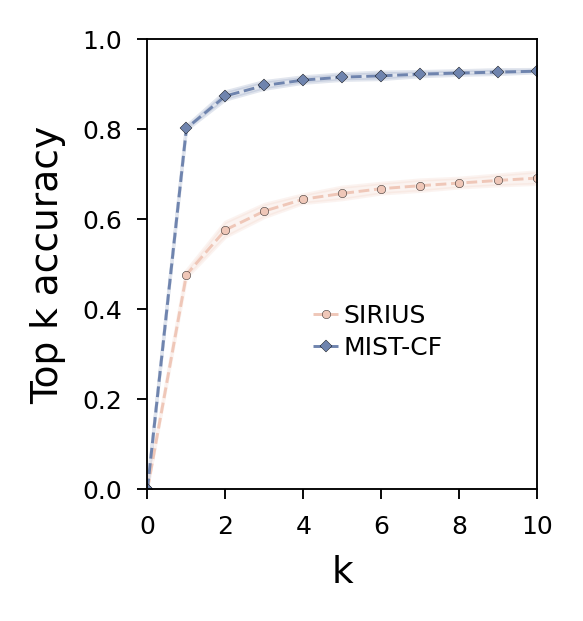

In [17]:
# Here just show the "with nist " result
# Plot out df as a line plot where each line is specific to a model, k is the x acc, and "acc" is the y axis
# Also use the splits to fill in the lines with error/deviation
# Plot the mean of the splits as a line, and the std as a shaded region

# TODO: Switch this from ind_found_full_form to having _multiple_ lines for full form and ind_found to show both..


figsize = (1.3,1.5)

# Filter outdf to only include splits with nist 
# Create two subplots
fig = plt.figure(figsize=figsize, dpi=300,)

# Add subplot
ax = fig.add_subplot(111)

# key_to_linestyle 

for method in sirius_order:
    subdf = out_df[out_df["model"] == method]

    mean_df = subdf.groupby("k").mean()
    std_df = subdf.groupby("k").std()
    # Get number of splits
    n_splits = subdf["split"].nunique()
    # Get stderror of mean and 95% conf
    std_err = std_df / np.sqrt(n_splits)
    conf = std_err * 1.96

    # Sort dfs by k 
    mean_df = mean_df.sort_index()
    conf = conf.sort_index()
    
    # Plot mean
    ax.plot(mean_df.index, mean_df["acc"], 
            label=rename_scheme[method],
            color=color_scheme[method],
            marker=marker_scheme[method], 
            # Add marker outline in black
            markeredgecolor="black",
            markeredgewidth=0.1,
            markersize=2,
            linewidth=0.7, 
            linestyle="--"
            )

    # Plot conf
    ax.fill_between(mean_df.index,
                    mean_df["acc"] - conf["acc"],
                    mean_df["acc"] + conf["acc"],
                    alpha=0.2,
                    color=color_scheme[method],)
    
ax.set_xlabel("k")
ax.set_ylabel("Top k accuracy")
ax.set_ylim(0.0,1)
uplim = 10
ax.set_xlim(0,uplim)
ax.set_xticks(np.arange(0, uplim +1, 2))
# ax.set_yscale("log")

# Make legend with no box
ax.legend(bbox_to_anchor=(0.4, 0.35), borderaxespad=0., 
        frameon=False, labelspacing=0.3, handletextpad=0.2,
        handlelength=1, loc="center left", ncol=1, )#fontsize=6)

# Remake legend but this time create slightly longer lines for all lineplots
# Create legend handles
ax.legend(bbox_to_anchor=(0.4, 0.35), borderaxespad=0.,
        frameon=False, labelspacing=0.3, handletextpad=0.2,
        handlelength=1, loc="center left", ncol=1, 

        )



# fig.tight_layout()
# Save to fig folder
set_size(*figsize, ax,)
fig.savefig(fig_folder / "lineplot_accuracy.pdf", bbox_inches="tight", transparent=True)

## Mass bins 

**Note this current implementation does not correct for differing denominators**

In [18]:
# Group by method, split, and compute top k accuracy through 20
def top_k_accuracy(x, top_k, denom, key_str="ind_found"):
    k_dict = []
    for k in top_k: 
        acc = np.sum(x[key_str] <= k)  / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict

top_k = list(range(0,21))
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split", "mass_bin"]
# key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
key_strs = ["ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        fold_specs = fold_to_specs[get_spec_num(names[1])]
        denom = len([i for i in fold_specs if spec_to_bin[i] == names[2]])
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str, denom=denom)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts ])
        
# print(out_df)
out_df = pd.DataFrame(out_df)
out_df.head()

,k,acc,model,split,mass_bin,val
0,0,0.000000,mist_cf_ms2,mist_cf_1,"[0, 200]",ind_found_full_form
1,1,0.957447,mist_cf_ms2,mist_cf_1,"[0, 200]",ind_found_full_form
2,2,0.971631,mist_cf_ms2,mist_cf_1,"[0, 200]",ind_found_full_form
3,3,0.971631,mist_cf_ms2,mist_cf_1,"[0, 200]",ind_found_full_form
4,4,0.971631,mist_cf_ms2,mist_cf_1,"[0, 200]",ind_found_full_form


In [19]:
## Subset to k = 1, split has nist
out_df_nist = out_df[(out_df["k"] == 1) ]
mass_bins = out_df_nist['mass_bin'].unique()
x_ticks = np.arange(len(mass_bins))
x_ticks_dict = dict(zip(mass_bins, x_ticks))
out_df_nist['x'] = out_df_nist['mass_bin'].map(x_ticks_dict)
out_df_nist;

/tmp/ipykernel_1567906/1390395285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df_nist['x'] = out_df_nist['mass_bin'].map(x_ticks_dict)


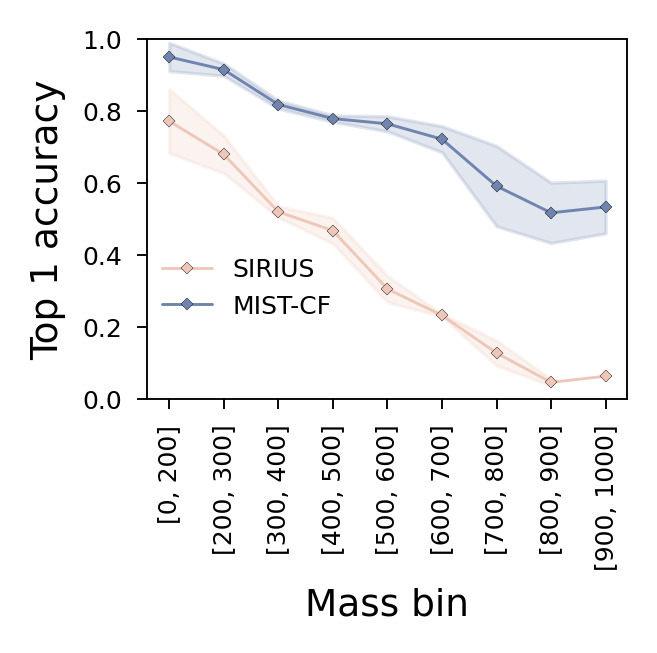

In [20]:

figsize = (1.6,1.2)
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111)
for model in sirius_order:
    subdf = out_df_nist[out_df_nist["model"] == model]
    mean_df = subdf.groupby("x").mean()
    std_df = subdf.groupby("x").std()
    # Get number of splits
    n_splits = subdf["split"].nunique()
    # Get stderror of mean and 95% conf
    std_err = std_df / np.sqrt(n_splits)
    conf = std_err * 1.96

    # Sort dfs by k 
    mean_df = mean_df.sort_index()
    conf = conf.sort_index()

    
    # Plot mean
    ax.plot(mean_df.index, mean_df["acc"], 
            label=rename_scheme[model], 
            color=color_scheme[model],
            markeredgecolor="black",
            markeredgewidth=0.1,
            markersize=2,
            linewidth=0.7,
            marker=marker_scheme[method], 
            )

    # Plot conf
    ax.fill_between(mean_df.index,
                    mean_df["acc"] - conf["acc"],
                    mean_df["acc"] + conf["acc"],
                    alpha=0.2,
                    color=color_scheme[model])
    
ax.set_xlabel("Mass bin")
ax.set_ylabel("Top 1 accuracy")
ax.set_ylim(0.,1)

# Set x tick labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(mass_bins, rotation=90)


# Make legend with no box
ax.legend(bbox_to_anchor=(0.01, 0.42), loc=2, borderaxespad=0., frameon=False,
                # Less padding
                # handletextpad=0.2,
)
# fig.tight_layout()
# Save to fig folder
set_size(*figsize, ax,)
fig.savefig(fig_folder / "top_k_acc_masses.pdf", bbox_inches="tight", transparent=True)

## Head to head dot plot

In [21]:

figsize = (1.5,1.5)

# Filter outdf to only include splits with nist 
# Create two subplots
fig = plt.figure(figsize=figsize, dpi=300,)


<Figure size 450x450 with 0 Axes>

In [22]:
# Add column to all df of split num
all_df['split_num'] = all_df['split'].apply(get_spec_num)

In [23]:
key = "ind_found_full_form"
max_bucket = 4

heat_df = all_df.copy()
# clip "ind_found_full_form" to max bucket
heat_df['ind_found_full_form'] = heat_df['ind_found_full_form'].clip(0, max_bucket)
heat_df['ind_found_full_form'] = heat_df['ind_found_full_form'].astype(int)

# Pivot df to be spec as index, model as columns, and ind found as values
heat_df = heat_df.pivot(index=["spec", "split_num"], columns="model", values="ind_found_full_form")

# Fill na with max bucket
heat_df = heat_df.fillna(max_bucket)
# Convert to int
heat_df = heat_df.astype(int)
heat_df = heat_df.reset_index()
# Groupby the mist_cf_ms2 and sirius values and compute count of specs in each
heat_df = heat_df.groupby(["mist_cf_ms2", "sirius"]).count()
heat_df = heat_df.reset_index()
heat_df['spec'].sum()
heat_df.head()
# Remove "split_num" from column

model,mist_cf_ms2,sirius,spec,split_num
0,1,1,2951,2951
1,1,2,576,576
2,1,3,238,238
3,1,4,1515,1515
4,2,1,122,122


In [24]:
heat_df.pivot(index="sirius", columns="mist_cf_ms2", values="spec")

mist_cf_ms2,1,2,3,4
sirius,,,,
1,2951,122,28,38
2,576,51,16,12
3,238,19,6,12
4,1515,281,104,613


In [25]:
cmap = sns.color_palette("light:b", as_cmap=True)

100.0


mist_cf_ms2,1,2,3,4
sirius,,,,
4,23.017320,4.269219,1.580067,9.313279
3,3.615922,0.288666,0.091158,0.182315
2,8.751139,0.774840,0.243087,0.182315
1,44.834397,1.853540,0.425403,0.577332


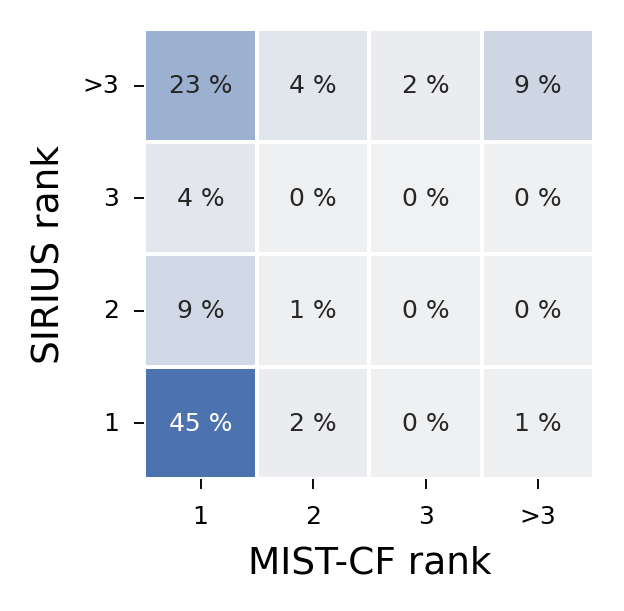

In [26]:
# Build heatmap 
figsize = (1.5,1.5)
fig = plt.figure(figsize=figsize, dpi=300,)
ax = fig.add_subplot(111)
hmap_ax = ax
# Build heatmap

plt_mat = heat_df.pivot(index="sirius", columns="mist_cf_ms2", values="spec")
plt_mat = plt_mat.fillna(0)
plt_mat = plt_mat / plt_mat.sum().sum() * 100
print(plt_mat.sum().sum())
# Put x labels above the heatmap
# Reverse sort rows
plt_mat = plt_mat.sort_index(ascending=False)
display(plt_mat)

sns.heatmap(plt_mat,
            ax=ax,
            cmap=cmap,

            # Plot numbers on top 
            annot=True,
            fmt = '.0f', square=1, 
            linewidth=0.5,
            # Set size of annot
            annot_kws={"size": 6},
            # Shrink cbar
            # set cbar to have min 0 and max 100
            vmin=0, #vmax=100,
            cbar_kws={"shrink": 0.5,}, 
            cbar = False,
)
for t in ax.texts: t.set_text(t.get_text() + " %")
# Set cbar to percentage labels
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels([f"{i}%" for i in [0, 25, 50, 75, 100]])

ax.set_xlabel("MIST-CF rank")
ax.set_ylabel("SIRIUS rank")
# Set x ticks
# Make sure that the last bucket for 6 has string text ">max_bucket - 1"
tick_vals = np.arange(1, max_bucket + 1)
ticks =  tick_vals + 0.5
# ax.set_xticks(ticks)
# Relabel all ticks to have >5 in the last one
ticks = ax.get_xticklabels()
ticks = [int(i.get_text()) for i in ticks]
ax.set_xticklabels([f"{i}" if i != max_bucket else f">{max_bucket - 1}" for i in ticks], rotation=0)

# Switch x tick labels to be on top of plot
# ax.xaxis.tick_bottom()
# ax.xaxis.set_label_position('top')
# ax.yaxis.s

# Get current y tick text labels
ticks = ax.get_yticklabels()
ticks = [int(i.get_text()) for i in ticks]

ax.set_yticklabels([f"{i}" if i != max_bucket else f">{max_bucket - 1}" for i in ticks], rotation=0)

# Save fig
set_size(*figsize, hmap_ax,)
# Set aspect to 1
hmap_ax.set_aspect(1)
fig.savefig(fig_folder / "heatmap.pdf", bbox_inches="tight", transparent=True)
